In [1]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import datetime as dt

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Loading Data

In [3]:
df = pd.read_csv('/Users/alex/Downloads/20171101_1857_sample.csv',parse_dates=['created_at'])
dataSize = df.shape
print("Data loaded: {}".format(dataSize))

Data loaded: (1334, 9)


# anon_email - user email address (the username is irrelevant, only the domain) -> take only the domain

In [4]:
df['email_domain'] = df.apply(lambda row: row['anon_email'].split("@")[1],axis=1)

In [5]:
df.head()

,id,created_at,shipping_country_code,billing_country_code,total_spent,avs_segment,historical_order_cnt,target,anon_email,email_domain
0,174662986,2017-04-02 17:54:44.498062,GB,GB,332.415532,Match,0,1,pjerqx@gmail.com,gmail.com
1,183355810,2017-04-25 17:52:50.809680,US,US,1471.570000,Match,1,0,jsruah@gmail.com,gmail.com
2,146842061,2017-01-08 18:18:47.829914,GB,GB,368.638679,Match,3,1,lpqbrg@outlook.com,outlook.com
3,182977614,2017-04-24 14:43:36.677016,GB,GB,2287.285631,Match,0,1,smfzet@gmail.com,gmail.com
4,147740922,2017-01-10 20:58:34.380204,US,US,295.000000,Match,3,0,tboahs@gmail.com,gmail.com


In [6]:
df = df.drop('anon_email',axis=1)

# look for Nans

In [7]:
categorical = ['shipping_country_code','billing_country_code','avs_segment','email_domain']
numerical = ['historical_order_cnt','total_spent','target']
pd.isnull(df).sum()

id                       0
created_at               0
shipping_country_code    0
billing_country_code     0
total_spent              0
avs_segment              0
historical_order_cnt     0
target                   0
email_domain             0
dtype: int64

# Categorical unique values:

In [8]:
for dim in categorical:
    print(dim+':')
    print(df[dim].unique())


shipping_country_code:
['GB' 'US' 'CA' 'IT' 'LT' 'HK' 'CH' 'AU' 'DE' 'BE' 'SG' 'KW' 'FR' 'HU' 'AE'
 'SE' 'EE' 'TR' 'DK' 'FI' 'ES' 'SK' 'RU' 'PT' 'IE' 'MY' 'AT' 'PL' 'LU' 'JP'
 'NL' 'TW' 'CZ' 'GR' 'SI' 'MT' 'CY' 'BG' 'LV' 'QA' 'RO' 'KR']
billing_country_code:
['GB' 'US' 'CA' 'IT' 'NO' 'CN' 'CH' 'AU' 'LC' 'BE' 'IN' 'KW' 'JP' 'FR' 'HU'
 'AE' 'SE' 'DE' 'VN' 'EE' 'MX' 'KZ' 'DK' 'FI' 'ES' 'SK' 'HK' 'RU' 'PT' 'IE'
 'MY' 'TR' 'AT' 'TH' 'AG' 'PL' 'LU' 'KR' 'SG' 'BR' 'CY' 'NL' 'TT' 'LY' 'GR'
 'GA' 'SI' 'SA' 'TW' 'MT' 'CO' 'UA' 'CZ' 'CR' 'HN' 'DO' 'BG' 'LV' 'EC' 'LK'
 'RO' 'JM' 'MZ' 'PH' 'ZA']
avs_segment:
['Match' 'Missing' 'No Match']
email_domain:
['gmail.com' 'outlook.com' 'qq.com' 'vip.qq.com']


# Distributions in the dataset

In [9]:
def calculateRate(x,y):
    output = x/float(y)
    return output

ALPHA = 0.05

def calculateError(q, N, alpha):
    from scipy.stats import norm
    z = norm.ppf(1 - alpha / 2)
    sigma = np.sqrt(q * (1 - q))
    error = sigma * z / np.sqrt(N)
    return error

1    0.718141
0    0.281859
Name: target, dtype: float64

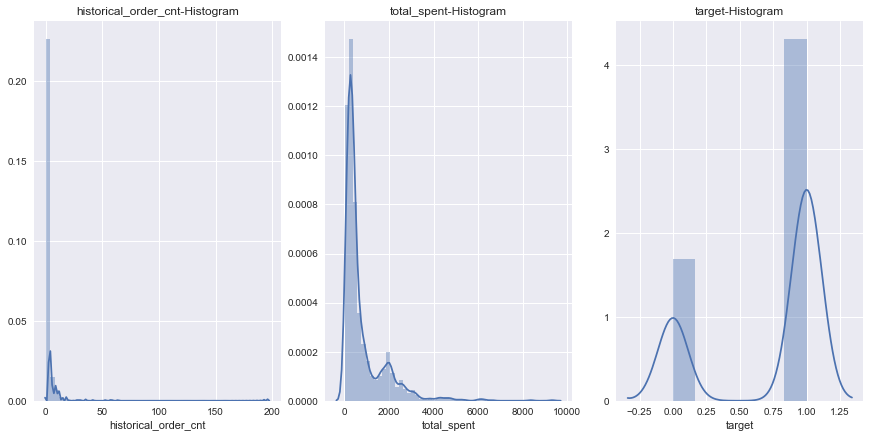

In [10]:
i=1
plt.figure(figsize=(12,6))
for dim in numerical:
    plt.subplot(1,3,i)
    sns.distplot(df[dim])
    plt.title(dim+'-Histogram')
    i=i+1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
df['target'].value_counts(normalize=True)

<p style="font-size:20px"><span style="color:red">
The data seems to be very skewed - for model creation i probably would have cut the tails...
</span>

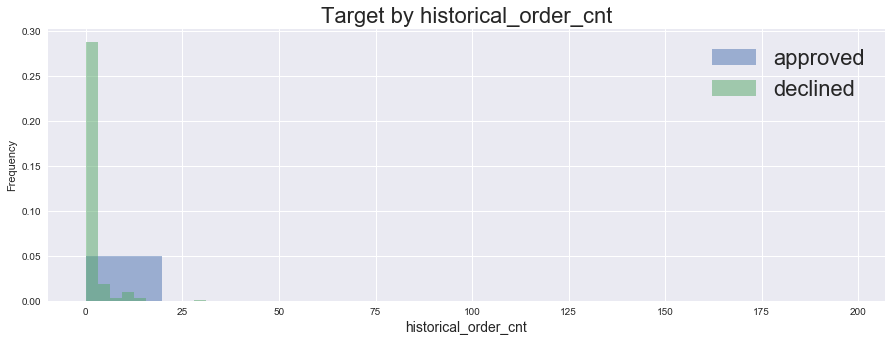

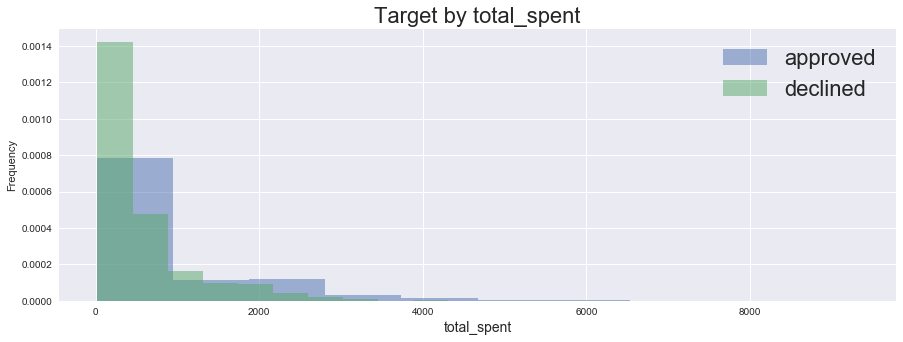

In [11]:
for dim in ['historical_order_cnt','total_spent']:
    plt.figure(figsize=(15,5))
    ax = df.query('target == 1')[dim].plot.hist(label='approved', normed=True, alpha=0.5)
    df.query('target == 0')[dim].plot.hist(label='declined', normed=True, alpha=0.5)
    plt.scatter
    plt.legend(fontsize=22)
    ax.set_xlabel(dim, fontsize=14)
    plt.title('Target by '+dim, fontsize=22)

<p style="font-size:20px"><span style="color:red">
It does seems like as higher the order-count or total-spent its more likely (doesnt looks like a strong feature) to be approved </span>

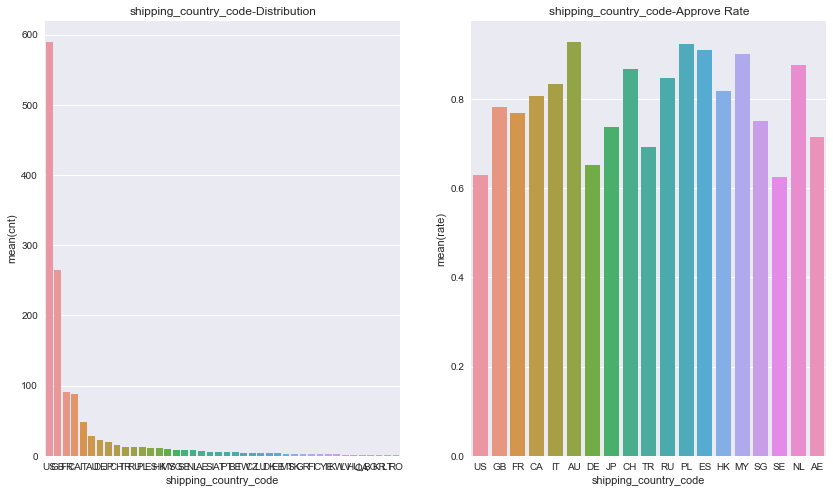

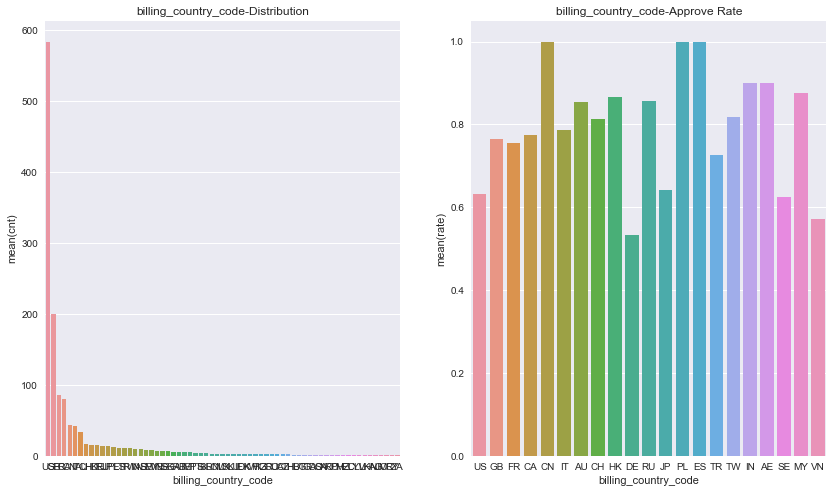

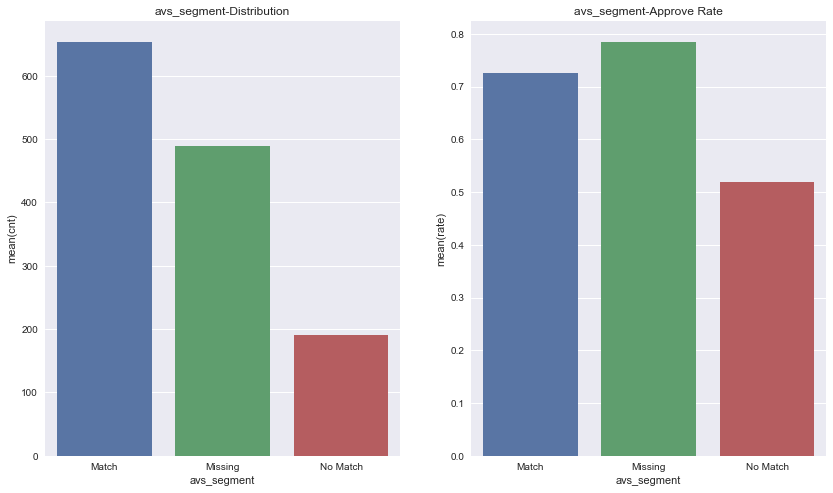

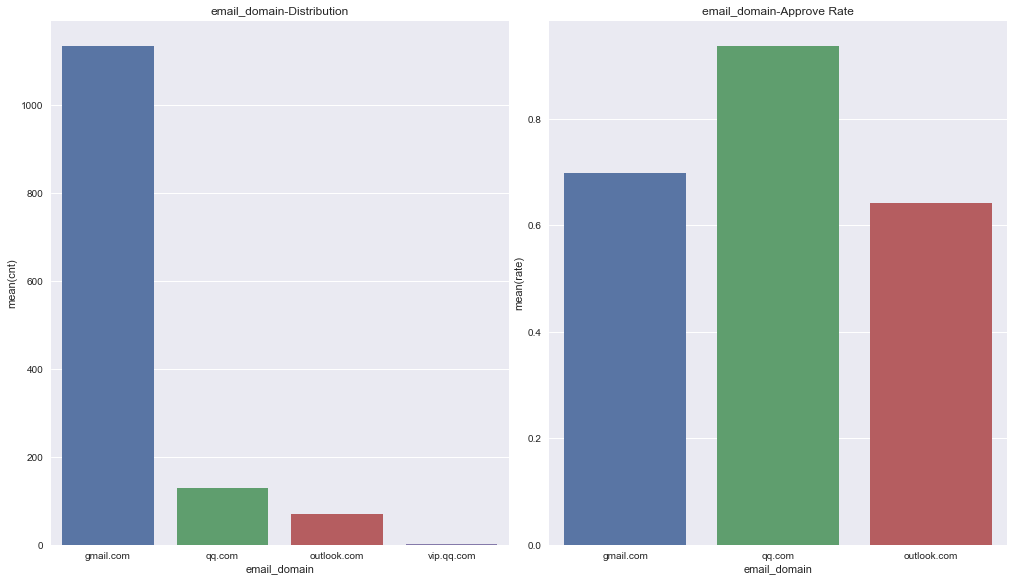

In [12]:
for dim in categorical:
    df_grouped = df.groupby([dim]).agg({'id':'count','target':'sum'})\
    .reset_index().rename(columns={'id': 'cnt', 'target': 'pos'}).sort_values(['cnt'],ascending=False)
    df_grouped['rate'] = df_grouped.apply(lambda row: calculateRate(row['pos'] , row['cnt']),axis=1)
    plt.figure(figsize=(14,8))
    plt.subplot(1,2,1)
    sns.barplot(df_grouped[dim],df_grouped['cnt'])
    plt.title('{}-Distribution'.format(dim))
    plt.subplot(1,2,2)
    df_grouped_filtered = df_grouped[df_grouped['cnt']/dataSize[0]>=0.005]
    sns.barplot(df_grouped_filtered[dim],df_grouped_filtered['rate'])
    plt.title('{}-Approve Rate'.format(dim))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)



<p style="font-size:20px"><span style="color:red">
In the graphs above, it is clear that most of the countries we do not have suffienct data (~10 countries contains about 90% of the transactions).<br>
I calculated the approveRate and filtered out data dimensions that are less than 0.5% of the data to make the graphs a little more clean.<br> 
I looked for variance in approved rate between different values in a categorical features-> as higher the variance it most likley to be a good feature in a model.
</span>

# Correlations between features (amond themselves as well) & target

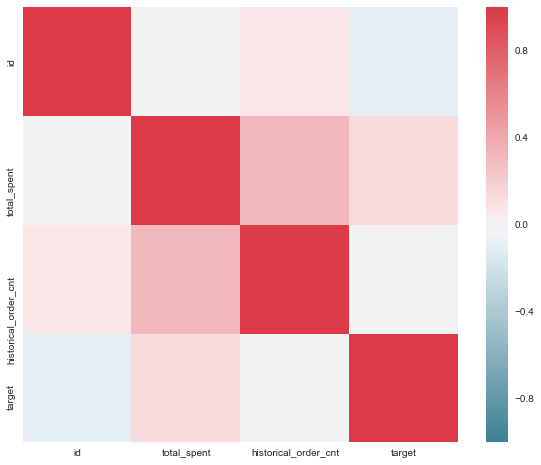

In [13]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

<p style="font-size:20px"><span style="color:red">
Order Count & Total spent seems to be a little correlated. <br>
total spend seems to be correlated to target.

Given more time - i would test correrlation between categorical features as well...
</span>